In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.graphics.tsaplots import plot_acf
import datetime
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display

In [2]:
df_combined = pd.read_csv('data/2022-2024_Stats.csv')

# Model Training

## Let users choose between Weekly or Monthly

In [3]:
# Define button options and their corresponding parameters
button_options = {
    "Weekly": {"train_days": df_combined[-60:], "num_steps": 6, "p": 7, "d": 1, "q": 2,
               "start_date": pd.Timestamp('2024-03-25'), "td_days": 6},
    "Monthly": {"train_days": df_combined[-100:], "num_steps": 29, "p": 7, "d": 1, "q": 1,
               "start_date": pd.Timestamp('2024-03-25'), "td_days": 29}
}

# Define a function to handle button clicks
def on_button_clicked(b):
    global clicked_button, train_days, num_steps, p, d, q, start_date, end_date
    clicked_button = b.description
    print("Button clicked:", clicked_button)

    # Update parameters based on the clicked button
    parameters = button_options.get(clicked_button)
    if parameters:
        train_days = parameters["train_days"]
        num_steps = parameters["num_steps"]
        p, d, q = parameters["p"], parameters["d"], parameters["q"]
        start_date = parameters["start_date"].date()
        td_days = parameters["td_days"]
        end_date = start_date + timedelta(days=td_days)
        print(len(train_days), num_steps, p, d, q, start_date, end_date, td_days)

# Create buttons
buttons = [widgets.Button(description=option) for option in button_options]

# Assign callbacks to buttons
for button in buttons:
    button.on_click(on_button_clicked)

# Display buttons
display(*buttons)


Button(description='Weekly', style=ButtonStyle())

Button(description='Monthly', style=ButtonStyle())

Button clicked: Weekly
60 6 7 1 2 2024-03-25 2024-03-31 6


## Predict based on whether Weekly or Monthly

In [ ]:
def arima_forecast(train_days, num_steps, p, d, q, var_to_pred):
    # Extract the 'Open Balances' column
    combined_train_data = train_days[var_to_pred]

    # Initialize history with combined training data
    history = [x for x in combined_train_data]
    #print(history, type(p))

    predictions = list()

    # Iterate over the number of time steps to make predictions for 2024
    for i in range(num_steps):
        # Fit ARIMA model with seasonal differencing
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit()

        # Forecast the next value
        yhat = model_fit.forecast()[0]
        # Append the forecasted value to predictions
        predictions.append(yhat)

        # Update the history with the forecasted value
        history.append(yhat)

    # Now predictions_2024 contains the predicted values for 2024
    print(predictions)
    return predictions


In [ ]:
predictions = arima_forecast(train_days, num_steps, p, d, q, var_to_pred='New Cases')

## Analyse Prediction Accuracy

In [ ]:
def analyse_pred(df_combined, predictions, start_date, end_date, var_to_pred):
    # Create time index
    time_index_2024 = pd.date_range(start=start_date, end=end_date, freq='D')

    # Plotting
    plt.figure(figsize=(10, 6))

    #plt.plot(time_index_2024, open_balances_values, label='Correct 2024', color='blue')

    # Plot predicted values for 2024
    plt.plot(time_index_2024, predictions, label='Predictions 2024', color='red')
    plt.title('ARIMA Forecast on ' + var_to_pred)
    plt.xlabel('Date')
    plt.ylabel(var_to_pred)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
analyse_pred(df_combined, predictions, start_date, end_date, var_to_pred='New Cases')

# New Cases: Dynamic Updating of ARIMA

Currently only works if you update for one day

In [4]:
# only putting this here in case i need to clear input
df_combined = pd.read_csv('data/2022-2024_Stats.csv')
df_combined

,Date,Open Balances,Closed,New Cases
0,2022-01-01,1963,0,468
1,2022-01-02,2431,0,503
2,2022-01-03,2934,857,1212
3,2022-01-04,3146,727,1039
4,2022-01-05,3368,949,826
...,...,...,...,...
810,2024-03-21,2521,429,428
811,2024-03-22,2499,432,406
812,2024-03-23,2473,11,211
813,2024-03-24,2673,0,214


In [5]:
# input updated numbers for today

open_balance_input = input("Enter today's Open Balance: ")
close_balance_input = input("Enter today's Close Balance: ")
new_balance_input = input("Enter today's New Balance: ")

original_data = []

# this code causes us to only be able to input 1 day of real values.
# need to find a way to make this more dynamic but for now its workable
train_days = df_combined[-60:]

try:
    open_balance = float(open_balance_input)
    close_balance = float(close_balance_input)
    new_balance = float(new_balance_input)
except ValueError:
    print("Error: Please enter valid numbers for balances.")
else:
    original_data.append(df_combined.iloc[-1])
    train_days = train_days.drop(df_combined.index[-1])
    new_data = {'Date': start_date,
                'Open Balances': open_balance,
                'Closed': close_balance,
                'New Cases': new_balance
                }
    train_days = train_days.append(new_data, ignore_index=True)
    print("Values successfully added to DataFrame.")
    print(train_days[-7:])
    print(original_data)

Enter today's Open Balance: 1234
Enter today's Close Balance: 4321
Enter today's New Balance: 115
Values successfully added to DataFrame.
          Date  Open Balances  Closed  New Cases
53  2024-03-19         2786.0   465.0      490.0
54  2024-03-20         2737.0   410.0      390.0
55  2024-03-21         2521.0   429.0      428.0
56  2024-03-22         2499.0   432.0      406.0
57  2024-03-23         2473.0    11.0      211.0
58  2024-03-24         2673.0     0.0      214.0
59  2024-03-25         1234.0  4321.0      115.0
[Date             2024-03-25
Open Balances          2737
Closed                  466
New Cases               445
Name: 814, dtype: object]


/var/folders/9d/9y37blc53yz64mgqtz66xrrw0000gp/T/ipykernel_12477/3678164048.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_days = train_days.append(new_data, ignore_index=True)


In [6]:
def arima_dynamic_forecast(train_days, num_steps, p, d, q, var_to_pred):
    # Extract the 'Open Balances' column
    combined_train_data = train_days[var_to_pred]

    # Initialize history with combined training data
    history = [x for x in combined_train_data]

    predictions = list()

    # Iterate over the number of time steps to make predictions for 2024
    for i in range(num_steps):
        # Fit ARIMA model with seasonal differencing
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit()

        # Forecast the next value
        yhat = model_fit.forecast()[0]
        # Append the forecasted value to predictions
        predictions.append(yhat)

        # Update the history with the forecasted value
        history.append(yhat)

    # Now predictions_2024 contains the predicted values for 2024
    print(predictions)
    return predictions


In [7]:
dynamic_predictions = arima_dynamic_forecast(train_days, num_steps, p, d, q, var_to_pred='New Cases')

/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/user/opt/anaconda3/lib/python3.9/site-packages/st

[237.1392516295386, 232.59258726773376, 265.7919526645809, 289.23723813828633, 191.3908790821185, 159.67315709929548]


In [8]:
def analyse_dynamic_pred(df_combined, predictions, start_date, end_date, var_to_pred):
    # Create time index
    time_index_2024 = pd.date_range(start=start_date, end=end_date, freq='D')

    # Plotting
    plt.figure(figsize=(10, 6))
    
    original_values = [row[var_to_pred] for row in original_data]
    
    print(original_values)

    # plot real values
    plt.bar(time_index_2024[0], original_values, label='Correct 2024', color='blue')
    
    # Plot predicted values
    plt.plot(time_index_2024[1:], dynamic_predictions, label='Predictions 2024', color='red')
    plt.title('ARIMA Forecast on ' + var_to_pred)
    plt.xlabel('Date')
    plt.ylabel(var_to_pred)
    plt.legend()
    plt.grid(True)
    plt.show()

[445]


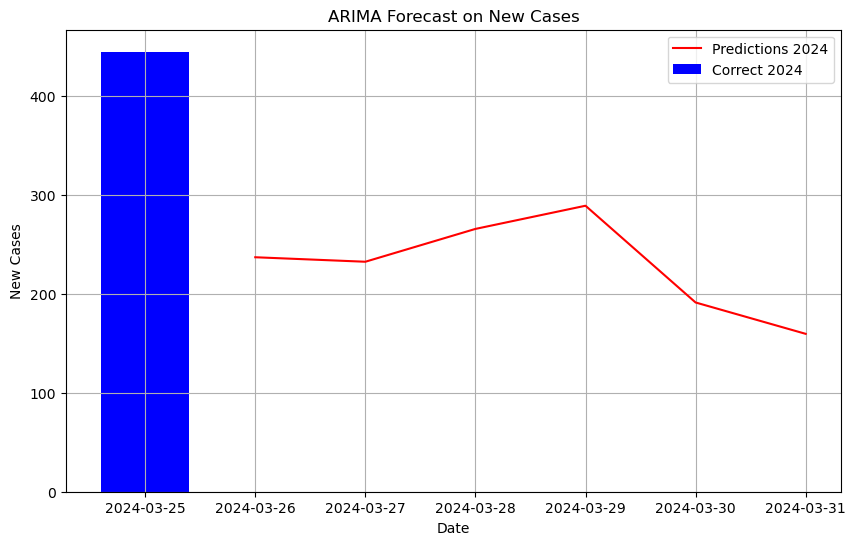

In [9]:
analyse_dynamic_pred(df_combined, dynamic_predictions, start_date, end_date, var_to_pred='New Cases')

# Closed Cases: Dynamic Updating of Simulation

# Open Balance: Dynamic Updating of Simulation